In [20]:
import argparse
import torch
import torch.optim as optim
import cv2
import pickle
import os
import time
import numpy as np

import utils
from painter import *
# from imitator import*
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [21]:
device

device(type='cuda', index=0)

In [25]:
args = {
    'train' : False,
    'img_path' : 'test_images/munk.jpg',
    'renderer' : 'oilpaintbrush',
    'canvas_color' : 'white',
    'canvas_size' : 512,
    'keep_aspect_ratio' : False,
    'max_m_strokes' : 91*16,
    'max_divide' : 6,
    'iterations_per_block' : 8*20,
    'beta_L1' : 1.0,
    'with_ot_loss' : False,
    'beta_ot' : 0.1,
    'net_G' : 'zou-fusion-net',
    'renderer_checkpoint_dir' : 'checkpoints_G_fix_w',
    'lr' : 0.005,
    'output_dir' : 'output',
    'disable_preview' : True,
    'max_num_epochs' : 400,
    'vis_dir' : 'val_out_G',
    'checkpoint_dir' : 'checkpoints_G_fix_w',
    'batch_size' : 64,
    'print_models' : False,
    'start_div' : 1,
    'replays' : 1,
    'kuka_width' : 300,  # in mm
    'kuka_height' : 300,  # in mm
    'x_shift' : 0.,  # in mm
    'y_shift' : 0.,  # in mm
    'n_colors': 8,
    'colors_dir' : 'colors',
    'save_video' : True,
    'max_h' : 0.1,
    'video' : 'MP4V'
}

In [26]:
total_blocks = sum(i**2 for i in range(args['start_div'], args['max_divide']+1))
total_blocks

91

In [27]:
#!g1.1
def optimize_x(pt):

    real_img = None
    pt._load_checkpoint()
    pt.net_G.eval()

    print('begin drawing...')

    PARAMS = np.zeros([1, 0, pt.rderr.d], np.float32)

    if pt.rderr.canvas_color == 'white':
        # CANVAS_tmp = torch.ones([1, 3, 128, 128]).to(device)
        CANVAS_tmp = torch.ones([args['start_div']**2, 3, 128, 128]).to(device)
    else:
        # CANVAS_tmp = torch.zeros([1, 3, 128, 128]).to(device)
        CANVAS_tmp = torch.ones([args['start_div']**2, 3, 128, 128]).to(device)

    iters_per_block = args['iterations_per_block']
    iters_per_stroke = int(iters_per_block / pt.m_strokes_per_block)
    print(f'Iterations per stroke : {iters_per_stroke}')

    for pt.m_grid in range(args['start_div'], pt.max_divide + 1):
        for replay in range(0, args['replays']):
            pt.batch_id += 1

            pt.img_batch = utils.img2patches(pt.img_, pt.m_grid, pt.net_G.out_size, adder=0.0).to(device)
            pt.G_final_pred_canvas = CANVAS_tmp

            pt.initialize_params()
            pt.x_ctt.requires_grad = True
            pt.x_color.requires_grad = True
            pt.x_alpha.requires_grad = True
            pt.x_w.requires_grad = True
            pt.x_h.requires_grad = True
            utils.set_requires_grad(pt.net_G, False)

            pt.optimizer_x = optim.RMSprop([pt.x_ctt, pt.x_color, pt.x_alpha, pt.x_w, pt.x_h], lr=pt.lr, centered=True)
            pt.step_id = 0
            for pt.anchor_id in range(0, pt.m_strokes_per_block):
                pt.stroke_sampler(pt.anchor_id) # anchor_id stroke is sampled in all blocks

                for i in range(iters_per_stroke):
                    pt.G_pred_canvas = CANVAS_tmp

                    # update x
                    pt.optimizer_x.zero_grad()

                    pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                    # pt.x_w.data = torch.clamp(pt.x_w.data, 0.02, args['max_w']*pt.m_grid)
                    # pt.x_h.data = torch.clamp(pt.x_h.data, 0.02, args['max_h']*pt.m_grid)
                    pt.x_w.data = torch.clamp(pt.x_w.data, 0.02, 0.9)
                    pt.x_h.data = torch.clamp(pt.x_h.data, 0.02, 0.9)
                    pt.x_color.data = torch.clamp(pt.x_color.data, 0, 0.9)
                    pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 0.9)

                    pt._forward_pass() # pt.x is created  #pt.G_final_pred_canvas is updated
                    pt._drawing_step_states()
                    pt._backward_x()

                    pt.x_ctt.data = torch.clamp(pt.x_ctt.data, 0.1, 1 - 0.1)
                    # pt.x_w.data = torch.clamp(pt.x_w.data, 0.02, args['max_w']*pt.m_grid)
                    # pt.x_h.data = torch.clamp(pt.x_h.data, 0.02, args['max_h']*pt.m_grid)
                    pt.x_w.data = torch.clamp(pt.x_w.data, 0.02, 1)
                    pt.x_h.data = torch.clamp(pt.x_h.data, 0.02, 1)


                    pt.x_color.data = torch.clamp(pt.x_color.data, 0, 1)
                    pt.x_alpha.data = torch.clamp(pt.x_alpha.data, 0, 1)

                    pt.optimizer_x.step()
                    pt.step_id += 1
            # all strokes are already rendered on pt.G_final_pred_canvas
            v = pt._normalize_strokes(pt.x)  # from patch coords to img coords
            v = pt._shuffle_strokes_and_reshape(v)
            PARAMS = np.concatenate([PARAMS, v], axis=1)
            CANVAS_tmp = pt._render(PARAMS, PARAMS.shape[1] - v.shape[1], save_jpgs=True, save_video=args['save_video'])
            print(CANVAS_tmp.shape)
            # z=utils.patches2img(CANVAS_tmp, CANVAS_tmp.shape[0], 0.)
            # plt.imshow(CANVAS_tmp)
            # plt.show()

            # if pt.batch_id < 1:
            #     if replay == args['replays'] - 1:
            #         CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size, adder=0.0).to(device)
            #     else:
            #         CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid, pt.net_G.out_size, adder=0.0).to(device)

            # else:


            # РИСУЕМ НА РОБОТЕ ТУТ И ЖДЕМ ПОКА ОТРИСУЕТ, потом выполняем код дальше
            # В файле KukaLogJSON в конструкторе есть путь до JSON куда писать команды - там надо указать путь куда писать JSON для батча
            # Тут надо указать ожидание откуда ждать файл что батч готов чтобы код запустился дальше
            experiment_uuid = 'f6d6f542-9996-42a8-bde4-055d5c30437e'
            batch_id = pt.batch_id

            robot_output_json_path = '/media/files/Legacy_API/kuka_api_v1/experiments/experiment_{}'.format(experiment_uuid)
            result_filepath = os.path.join(robot_output_json_path, 'batch_{}_out.pkl'.format(batch_id))

            with open('./exp_image/img_{}.txt'.format(batch_id), 'w+') as f:
                # arr.reshape(arr.shape[0], -1)
                np.savetxt('./exp_image/img_{}.txt'.format(batch_id), CANVAS_tmp.reshape(CANVAS_tmp.shape[0], -1)) # f.write(CANVAS_tmp)

            # while not os.path.exists(result_filepath):
            #     time.sleep(1)

            result_data = None
            # with open(result_filepath, 'rb') as f:
            #     result_data = pickle.load(f)

            with open('./exp_image/img_{}.txt'.format(batch_id), 'rb') as f:
                #result_data = f.readlines()
                result_data = np.loadtxt('./exp_image/img_{}.txt'.format(batch_id)).reshape(CANVAS_tmp.shape)

            # result_image = result_data['image']
            result_image = result_data

            # result_image = utils.preproc_camera_image(result_image)

            real_img = result_image
            # real_img_batch = utils.img2patches(real_img, pt.m_grid, pt.net_G.out_size, adder=0.0).to(device)
            CANVAS_tmp = real_img
            if replay == args['replays'] - 1:
                CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid + 1, pt.net_G.out_size, adder=0.0).to(device)
            else:
                CANVAS_tmp = utils.img2patches(CANVAS_tmp, pt.m_grid, pt.net_G.out_size, adder=0.0).to(device)


    pt._save_stroke_params(PARAMS)
    final_rendered_image = real_img #pt._render(PARAMS, save_jpgs=True, save_video=True)

    return final_rendered_image

initialize network with normal
Strokes per block : 16
loading renderer from pre-trained checkpoint...
begin drawing...
Iterations per stroke : 10
torch.Size([1, 3, 128, 128])
torch.Size([1, 3, 128, 128])
iteration step 0, G_loss: 0.00000, step_acc: 4.72347, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 1, G_loss: 0.50995, step_acc: 4.88346, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 2, G_loss: 0.49313, step_acc: 5.07094, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 3, G_loss: 0.47878, step_acc: 5.19596, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 4, G_loss: 0.46951, step_acc: 5.30149, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 5, G_loss: 0.46113, step_acc: 5.41409, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 6, G_loss: 0.45229, step_acc: 5.55134, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 7, G_loss: 0.44232, step_acc: 5.61782, grid_scale: 1 / 6, strokes: 1 / 16
iteration step 8, G_loss: 0.43722, step_acc: 5.77688, grid_scale: 1 / 6, strokes: 1 

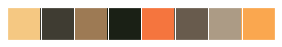

In [28]:
pt = ProgressivePainter(args=args)
final_rendered_image = optimize_x(pt)